In [34]:
from __future__ import print_function, division
import os
import torch
from numpy import newaxis
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# from dataset_generator_2 import DataLoader,Dataset_sat
import h5py
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from imgaug import augmenters as iaa
plt.ion()   # interactive mode
from image_utils import read_data_h5,standardize
from torch.autograd import Variable

In [35]:
PATH_INPUT='INPUT/'
PATH_OUTPUT='OUTPUT/'
NB_CLASSES=2


In [36]:
class Flip(object):
    """Flip ratio of the image Left/Right and up/down

    Args:
        ratio (int): how much of the image is flipped
    """

    def __init__(self,ratio):

        self.ratio = ratio

    def __call__(self, sample):
        X, Y = sample['input'], sample['groundtruth']
        seq = iaa.Sequential([iaa.Fliplr(0.5),iaa.Flipud(0.5)])
        data_tot=np.concatenate((X.astype('uint8'),Y.astype('uint8')),axis=2)
        data_tot=seq.augment_images(data_tot[newaxis,:,:,:])
        data_tot=np.squeeze(data_tot)
        X=data_tot[:,:,:X.shape[2]]
        Y=data_tot[:,:,X.shape[2]:]
        return {'input': X, 'groundtruth': Y}
    

In [37]:
def _parse_image(path_input,path_output,nb_classes):
    '''
    Reads and saves as as an array image input and output
    :paths_input path of the input image that have to be read  
    :paths_output path of the output image that have to be read  
    returns input and output image as array
    '''
    
    X=read_data_h5(path_input)
    Y_build=read_data_h5(path_output)
    Y_build=(Y_build>0).astype(int)
    Y_other= (1-Y_build).astype(int)
    Y=np.stack((Y_build,Y_other),axis=2)
            
#     inp=torch.LongTensor(Y_build)
#     inp_ = torch.unsqueeze(inp, len(Y_build.shape))
#     Y = torch.FloatTensor(Y_build.shape[0],Y_build.shape[1],nb_classes ).zero_()
#     Y.scatter_(len(Y_build.shape), inp_, 1)
#     Y=np.asarray(Y)
# OR
#     Y_build=torch.LongTensor(Y_build)
#     y_tensor = Y_build.data if isinstance(Y_build, Variable) else Y_build
#     y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
#     y_one_hot = torch.zeros(y_tensor.size()[0], nb_classes).scatter_(1, y_tensor, 1)
#     Y = y_one_hot.view(*Y_build.shape, -1)
    
    return X,Y

In [38]:
class Dataset_sat(Dataset):
    """Satellite images dataset with rastered footprints in groundtruth."""

    def __init__(self,paths_input: np.ndarray,paths_output: np.ndarray,nb_classes: int,transform=None):
        """
        Args:
            
        """
        self.paths_input = paths_input
        self.paths_output = paths_output
        self.nb_classes=nb_classes
        self.transform = transform
    @classmethod
    def from_root_folder(cls, root_folder: str, nb_classes: int,*,transform=None, max_data_size:  int = None):
        paths_input = []
        paths_output=[]
        
        
        for filename in sorted(os.listdir(root_folder+PATH_INPUT))[:max_data_size]:
            paths_input.append(os.path.join(root_folder+PATH_INPUT, filename))

        for filename in sorted(os.listdir(root_folder+PATH_OUTPUT))[:max_data_size]:

            paths_output.append(os.path.join(root_folder+PATH_OUTPUT, filename))
        
        
        return Dataset_sat(np.asarray(paths_input), np.asarray(paths_output),nb_classes)

    def __len__(self):
        return len(self.paths_input)
    
#     def shuffled(self):
# #         if seed is not None:
# #             np.random.seed(seed)

#         idx = np.arange(len(self.paths_input))
#         np.random.shuffle(idx)
#         generator = Dataset_sat(self.paths_input[idx], self.paths_output[idx],self.nb_classes)

#         return generator 

    def __getitem__(self, idx):
        
        X,Y=_parse_image(self.paths_input[idx],self.paths_output[idx],self.nb_classes)     
        sample = {'input': X, 'groundtruth': Y}

        if self.transform:
            sample = self.transform(sample)

        return sample

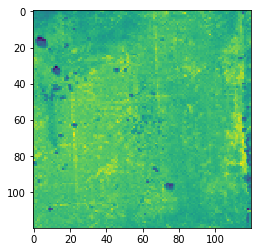

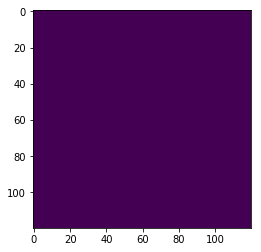

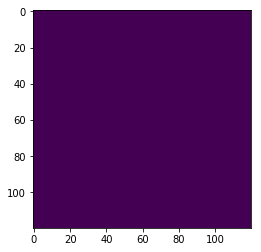

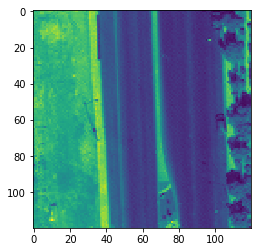

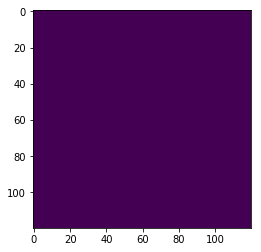

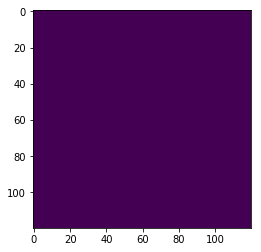

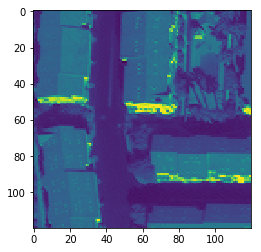

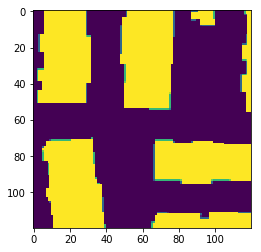

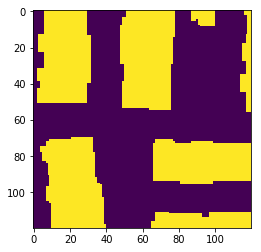

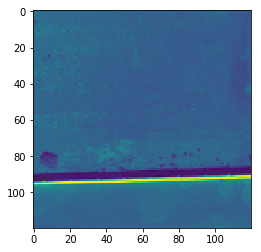

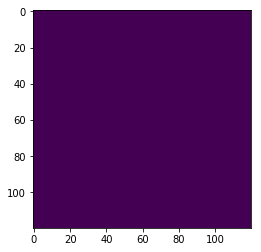

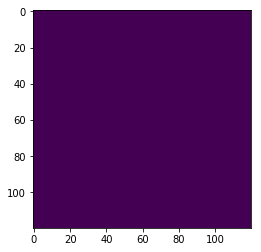

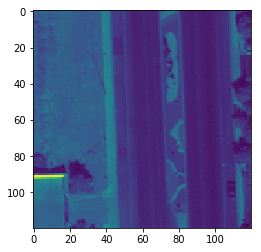

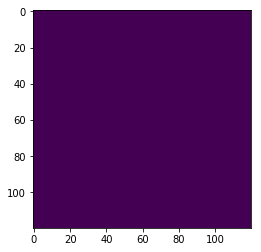

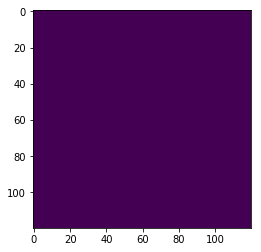

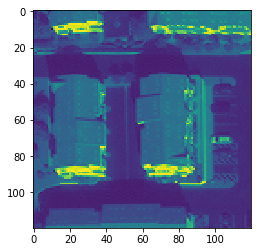

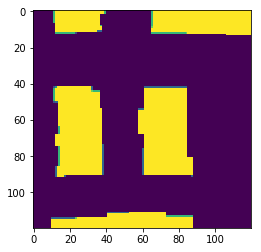

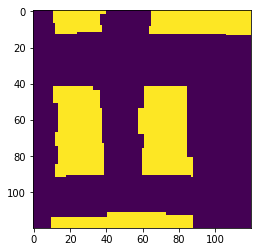

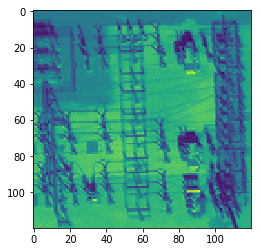

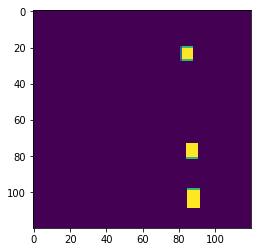

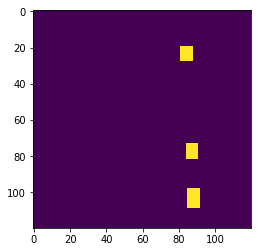

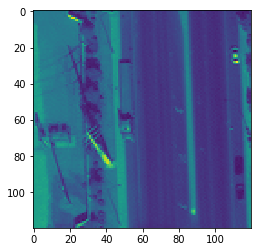

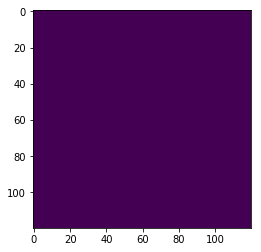

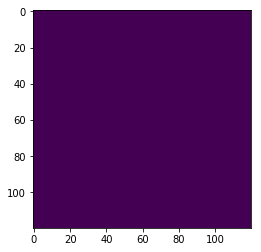

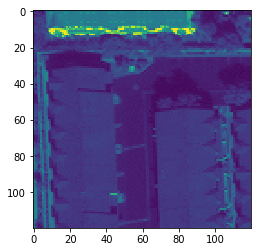

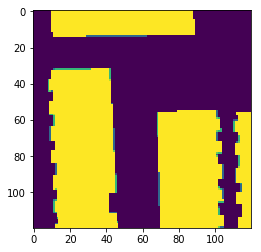

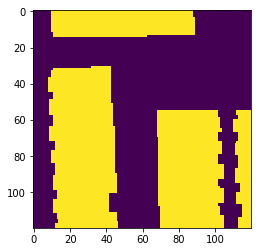

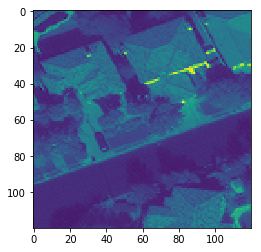

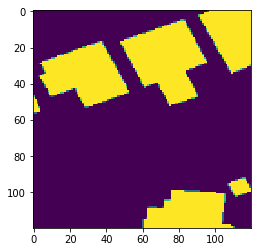

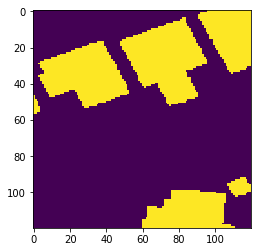

0 torch.Size([2, 120, 120, 9]) torch.Size([2, 120, 120, 2])
1 torch.Size([2, 120, 120, 9]) torch.Size([2, 120, 120, 2])
2 torch.Size([2, 120, 120, 9]) torch.Size([2, 120, 120, 2])
3 torch.Size([2, 120, 120, 9]) torch.Size([2, 120, 120, 2])


In [39]:
# root_folder = '../2_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/'
root_folder ='/scratch/SPACENET_DATA_PROCESSED/DATASET/120_x_120_8_bands_pansh/TEST/'

# composed = transforms.Compose([Rescale(256),transform=Flip(0.5)
#                                RandomCrop(224)])
generator=Dataset_sat.from_root_folder(root_folder,NB_CLASSES,max_data_size=10)
    
dataloader = DataLoader(generator, batch_size=2,shuffle=True, num_workers=4)

# trsfrm=Flip(0.5)
# sample_batch=generator.__getitem__(4)
# plt.imshow(sample_batch['input'][:,:,0])
# plt.show()
# t_sample_batch = trsfrm(sample_batch)
# plt.imshow(t_sample_batch['input'][:,:,0])
# plt.show()
    



for i_batch,sample_batch in enumerate(dataloader):
    print( i_batch,sample_batch['input'].size(),
          sample_batch['groundtruth'].size())
#     plt.imshow(sample_batch['input'][i_batch,:,:,0])
#     plt.show()
#     plt.imshow(sample_batch['groundtruth'][i_batch,:,:,0])
#     plt.show()

    
    if i_batch==3:
        break
        

test2=standardize(sample_batch['input'])